# Fourier neural operator

[项目主页](https://zongyi-li.github.io/blog/2020/fourier-pde/)

[代码仓库](https://github.com/neuraloperator/neuraloperator)

## 网络结构

![](https://content.lz1.fun/202304112137340.png)

In [1]:
import torch
from torch import nn
from functools import partial
import torch.nn.functional as F

下面我们首先定义FNO中的单个block，也就是上图中的黄框部分

In [2]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()
        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat)
        )

    def forward(self, x):
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x, dim=-1, norm="ortho")

        # Multiply relevant Fourier modes
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        out_ft = torch.zeros(
            x.shape[0], self.in_channels, x.size(-1) + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, : self.modes] =  torch.einsum("bix,iox->box",x_ft[:, :, : self.modes],self.weights)

        # Return to physical space
        x = torch.fft.irfft(out_ft, dim=-1, n=x.size(-1), norm="ortho")
        return x

然后一个完成FNO的一个block，这有若干个Fourier卷积和普通卷积组合而成。

In [3]:
class SimpleBlock1d(nn.Module):
    def __init__(self, inchannel, outchannel, modes, width, padding_mode, activation):
        super(SimpleBlock1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes = modes
        self.width = width
        self.inchannel = inchannel
        self.outchannel = outchannel
        self.padding_mode = padding_mode

        self.fc0 = nn.Linear(
            self.inchannel, self.width
        )  # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, self.outchannel)

        self.act=getattr(torch.nn, activation)()

    def forward(self, x):

        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = self.act(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = self.act(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = self.act(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

最后，一个FNO由若干个FNO块组成，我们这里选取最简单的由单块组成的网络。

In [4]:
class FNO1d(nn.Module):
    def __init__(
        self,
        in_channel=5,
        out_channel=1,
        modes=32,
        hidden=64,
        padding_mode="circular",
        activation="ReLU",
    ):
        super(FNO1d, self).__init__()
        self.conv1 = SimpleBlock1d(
            in_channel,
            out_channel,
            modes,
            width=hidden,
            padding_mode=padding_mode,
            activation=activation,
        )
    def forward(self, x):
        x = self.conv1(x)
        return x

至此，我们已经完成了FNO网络结构的定义。下面就是找一些数据来测试FNO的效果。我们使用之前写好的RTE求解器生成500组数据。

In [5]:
import math
import numpy as np
from torch.func import vmap
import torch.nn.functional as F

def get_gauss_point(n):
    x, w = np.polynomial.legendre.leggauss(n)
    return torch.from_numpy(x).to(dtype=torch.get_default_dtype()), torch.from_numpy(w).to(dtype=torch.get_default_dtype())

a = 1
c = 1
rho = 1
cv = 1

# spatial grid
N = 400
L = 1
dx = L / N
x = torch.arange(0.5 * dx, L + 0.5 * dx, dx)

Tini =  vmap(lambda cas:(1 + 0.1 * torch.sin(2 * math.pi * x * (1+cas%2) +torch.sin(cas)))*(1+torch.sin(cas)))(torch.arange(500))
sigma = vmap(lambda cas:(1 + 0.1 * torch.sin(2 * math.pi * x * (1+cas%2)  +torch.sin(cas+1)))*(1+torch.sin(cas)))(torch.arange(500))
    
def solve(Tini,sigma):
    CFL = 0.8
    dt = CFL * dx  # time step
    dtc = dt * c
    ddtc = 1 / dtc

    datarecord_sigma=sigma.clone()[None,:]
    
    # velocity grid & angle
    Nvx = 8
    mu, wmu = get_gauss_point(Nvx)

    # distribution function
    T = Tini
    I = 0.5 * a * c * Tini**4
    I = I.repeat(Nvx, 1)
    I = F.pad(I[None, ...], (1, 1), mode='circular')[0]
    I0 = wmu @ I  # energe
    sigma = sigma.repeat(Nvx // 2, 1)

    t=1.0
    Nt=int(t / dt)
    list_T=[]
    list_E=[]
    for loop in range(Nt):  #=1: 1/dt
        I_out = I.clone()
        T_out = T.clone()
        I0_out = I0.clone()

        index = slice(1, -1)
        index_add1 = slice(2, None)
        index_sub1 = slice(None, -2)

        # streaming, positive vx
        lv = slice(Nvx // 2, None)
        coe = mu[lv]
        I[lv, index] = I_out[lv, index] - dt / dx * coe[..., None] * (
            I_out[lv, index] - I_out[lv, index_sub1]) + dt * sigma * (
                (0.5 * a * c * T_out**4).repeat(Nvx // 2, 1) - I_out[lv, index])
        
        # streaming, negative vx
        lv = slice(0, Nvx // 2)
        coe = mu[lv]
        I[lv, index] = I_out[lv, index] - dt / dx * coe[..., None] * (
            I_out[lv, index_add1] - I_out[lv, index]) + dt * sigma * (
                (0.5 * a * c * T_out**4).repeat(Nvx // 2, 1) - I_out[lv, index])

        I = F.pad(I[None, ..., 1:-1], (1, 1), mode='circular')[0]
        T = T_out + dt / cv * sigma[0, :] * (I0_out[index] - a * c * T_out**4)
        I0 = wmu @ I

        if loop%10==0:
            list_E.append(I0[...,1:-1].clone())
            list_T.append(T.clone())
    datarecord_E=torch.stack(list_E,dim=0)
    datarecord_T=torch.stack(list_T,dim=0)
    return datarecord_E,datarecord_T,datarecord_sigma

E,T,sigma=vmap(solve)(Tini,sigma)
print(E.shape,T.shape,sigma.shape)

torch.Size([500, 50, 400]) torch.Size([500, 50, 400]) torch.Size([500, 1, 400])


然后我们将其包装成数据集，我们令输入是0时刻的E,T以及参数sigma，输出的是最后时刻的E和T. 我们这里对数据进行标准化。

In [6]:
x_data=torch.stack([E[:,0],T[:,0],sigma.expand_as(E)[:,0]],dim=-1)
y_data=torch.stack([E[:,-1],T[:,-1]],dim=-1)

x_data=(x_data-x_data.mean(dim=(0,1),keepdims=True))/x_data.std(dim=(0,1),keepdims=True)
y_data=(y_data-y_data.mean(dim=(0,1),keepdims=True))/y_data.std(dim=(0,1),keepdims=True)
print(f"{x_data.shape=},{y_data.shape=}")

x_train,y_train=x_data[:-20],y_data[:-20]
x_valid,y_valid=x_data[-20:],y_data[-20:]

train_dataset=torch.utils.data.TensorDataset(x_train,y_train)
valid_dataset=torch.utils.data.TensorDataset(x_valid,y_valid)

x_data.shape=torch.Size([500, 400, 3]),y_data.shape=torch.Size([500, 400, 2])


## 训练网络


In [7]:
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=2)
valid_dataloader=torch.utils.data.DataLoader(valid_dataset,batch_size=64,shuffle=False,num_workers=2)

myFNO=FNO1d(3,2)
#myFNO.cuda()
optimizer=torch.optim.Adam(myFNO.parameters(), lr=1e-3)
scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,100,2)
epochs=300

train_loss_hist=[]
valid_loss_hist=[]
for i in range(1,1+epochs):
    train_loss=0
    for x,y in train_dataloader:
        #x,y=x.cuda(),y.cuda()
        y_pred=myFNO(x)
        loss=(y_pred-y).square().mean()
        train_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_hist.append(train_loss/480)   
    scheduler.step()
    
    valid_loss=0
    for x,y in valid_dataloader:
        #x,y=x.cuda(),y.cuda()
        y_pred=myFNO(x)
        loss=(y_pred-y).square().mean()
        valid_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    valid_loss_hist.append(valid_loss/20)  
        
    if i%10==0:
        print(f"epoch:{i}, train loss: {train_loss}, valid loss: {valid_loss}")

epoch:10, train loss: 0.003175586462020874, valid loss: 0.00037672792677767575
epoch:20, train loss: 0.0002588716615719022, valid loss: 3.065231430809945e-05
epoch:30, train loss: 9.93086869129911e-05, valid loss: 1.1333598195051309e-05
epoch:40, train loss: 5.538810160032881e-05, valid loss: 6.490697160188574e-06
epoch:50, train loss: 2.024030345637584e-05, valid loss: 2.717382585615269e-06
epoch:60, train loss: 1.244708732883737e-05, valid loss: 1.421161186954123e-06
epoch:70, train loss: 9.589616411176394e-06, valid loss: 1.1114556173197343e-06
epoch:80, train loss: 8.339804935530992e-06, valid loss: 9.134378728958836e-07
epoch:90, train loss: 8.066567716014106e-06, valid loss: 8.570763725401775e-07
epoch:100, train loss: 7.9013756248969e-06, valid loss: 8.48483011850476e-07
epoch:110, train loss: 3.975824483859469e-05, valid loss: 2.010224670812022e-05
epoch:120, train loss: 0.00029864934731449466, valid loss: 7.92315840953961e-05
epoch:130, train loss: 0.00010102950159307511, vali

## 可视化结果

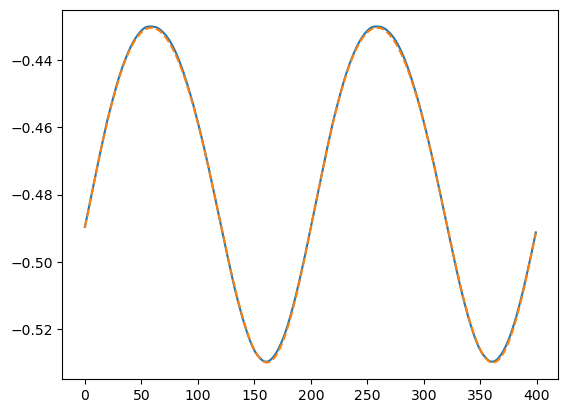

In [18]:
import matplotlib.pyplot as plt

y_pred=myFNO(x_valid)

plt.plot(y_pred[1,:,1].detach().cpu())
plt.plot(y_valid[1,:,1],"--")